<a href="https://colab.research.google.com/github/jainsanyam228/ML-Diabetic-Retinopathy-/blob/main/Explainable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from typeguard import typechecked
from typing import Optional
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/aptos_ml_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/aptos_ml_data/test.csv')
submission= pd.read_csv('/content/drive/MyDrive/aptos_ml_data/sample_submission.csv')

In [ ]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
from xgboost import XGBClassifier

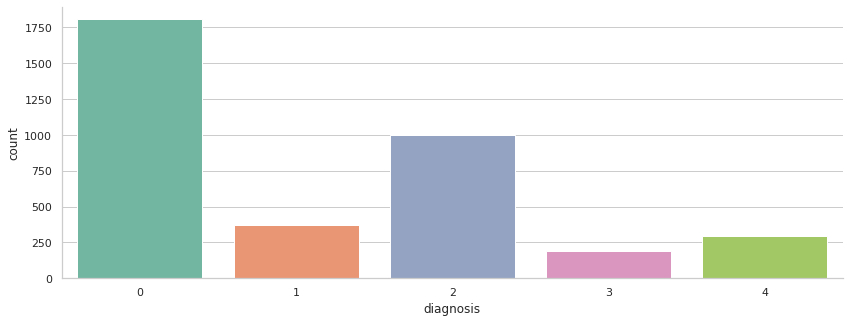

In [ ]:
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.show()

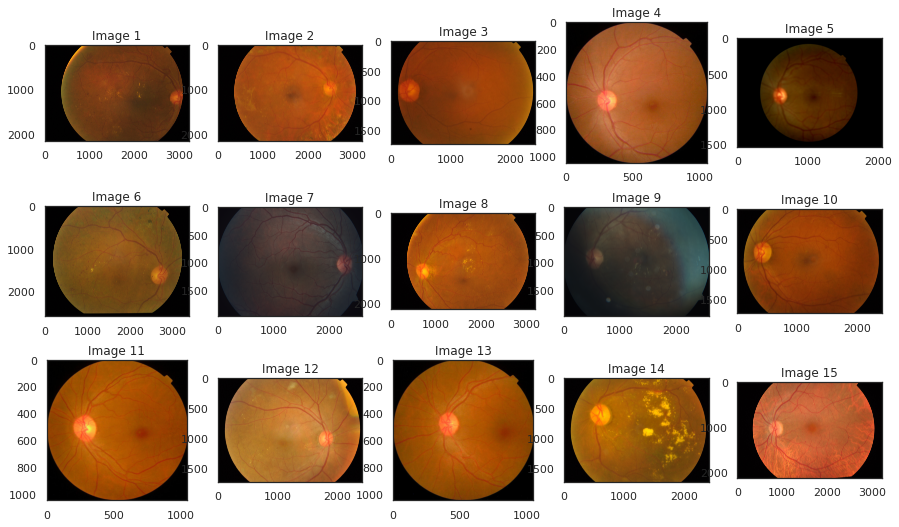

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[15, 15])
for img_name in train['id_code'][:15]:
    img = cv2.imread("/content/drive/MyDrive/aptos_ml_data/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

In [ ]:
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES

5

In [ ]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/aptos_ml_data/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')

Found 2930 validated image filenames belonging to 5 classes.


In [ ]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/aptos_ml_data/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=16,
    class_mode="categorical",
    target_size=(224, 224),
    subset='validation')

Found 732 validated image filenames belonging to 5 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/content/drive/MyDrive/aptos_ml_data/test_images",
        x_col="id_code",
        target_size=(224, 224),
        batch_size=16,
        shuffle=False,
        class_mode=None)

Found 1928 validated image filenames.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(activation='softmax', units=5))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                        

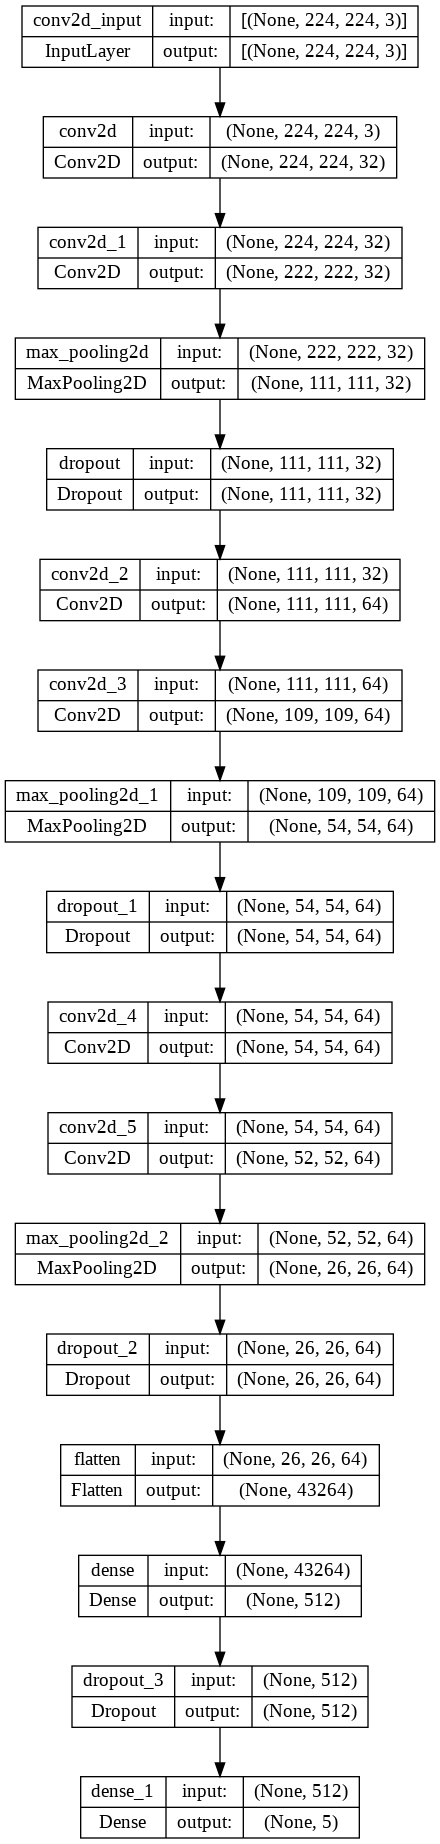

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet5.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet5.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.8, min_lr = 1e-6)

mcp = ModelCheckpoint('ownmodel.h5')

es = EarlyStopping(verbose=1, patience=2)

In [ ]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=METRICS)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [ ]:
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

183
45


In [ ]:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,epochs=2)

In [ ]:
model.save('/content/drive/MyDrive/modelEpoch2xi.h5')

In [ ]:
model.save('/content/drive/MyDrive/modelEpoch2xi_allFiles')

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
import tensorflow as tf

In [ ]:
import keras

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 28.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=559c85b2fc693b6ea96562620fd5c15cfd9f28fbcbc83b74c67f63558b6649ad
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from skimage import io
from tensorflow.keras.preprocessing import image

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/modelEpoch2xi.h5',custom_objects={f1_score:f1_score},compile=False)

In [ ]:
new_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                        

In [ ]:
new_model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=METRICS)

In [ ]:
import numpy as np

In [ ]:
def predict(model, img):


    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
class_names = ['1DR', '2DR', '3DR', '4DR', '5DR']

In [ ]:
history = new_model.history

In [ ]:
scores = new_model.evaluate_generator(valid_generator,STEP_SIZE_VALID,verbose =2)

45/45 - 321s - loss: 0.8263 - accuracy: 0.8822 - precision: 0.8231 - recall: 0.5236 - auc: 0.9131 - f1_score: 0.6339 - 321s/epoch - 7s/step


In [ ]:
print("%s: %.2f%%" % (new_model.metrics_names[1], scores[1]*100))

accuracy: 88.22%


In [ ]:
print(scores)

[0.8262593746185303, 0.8822222352027893, 0.8231440782546997, 0.5236111283302307, 0.9131389856338501, 0.6339353919029236]


In [ ]:
IMG_SIZE = (224, 224)
def predict1(model, img):


    img_array = tf.keras.preprocessing.image.img_to_array(img,IMG_SIZE )
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
from skimage import io

In [ ]:
xyz = read_image("/content/drive/MyDrive/aptos_ml_data/train_images/00a8624548a9.png")

In [ ]:
predict1(new_model ,images)

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
from skimage import io
from tensorflow.keras.preprocessing import image

In [ ]:
from keras.preprocessing import image

In [ ]:
image_func = load_img("/content/drive/MyDrive/aptos_ml_data/train_images/001639a390f0.png",target_size=(224,224),color_mode='rgb')

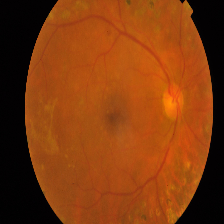

In [ ]:
image_func

In [ ]:
def read_image(img):
  image_func = load_img(img,target_size=(224,224),color_mode='rgb')
  img_array = tf.keras.preprocessing.image.img_to_array(image_func)
  img_array = tf.expand_dims(img_array, 0)
  return img_array

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
preds = new_model.predict(xyz2)
print(preds)

In [ ]:
prediction = np.argmax(preds)
pct = np.max(preds)
print(pct)

1.0


In [ ]:
xyz2 = "/content/drive/MyDrive/aptos_ml_data/train_images/00cc2b75cddd.png"

In [ ]:
path_to_zero = "/content/drive/MyDrive/aptos_ml_data/train_images/001639a390f0.png"

In [ ]:
images = read_image(path_to_zero)
images = np.array(images, dtype=np.double)

In [ ]:
print(images.size())

In [ ]:
explanation = explainer.explain_instance(images[0], new_model.predict,top_labels=1, hide_color=1, num_samples=10000)


In [ ]:
explanation = explainer.explain_instance(images[0].astype('double'), new_model.predict,
                                         top_labels=1, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 422ms/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
exp = explainer.explain_instance(images[0],
                                 model.predict,
                                 top_labels=5,
                                 hide_color=0,
                                 num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 435ms/step


(-0.5, 223.5, 223.5, -0.5)

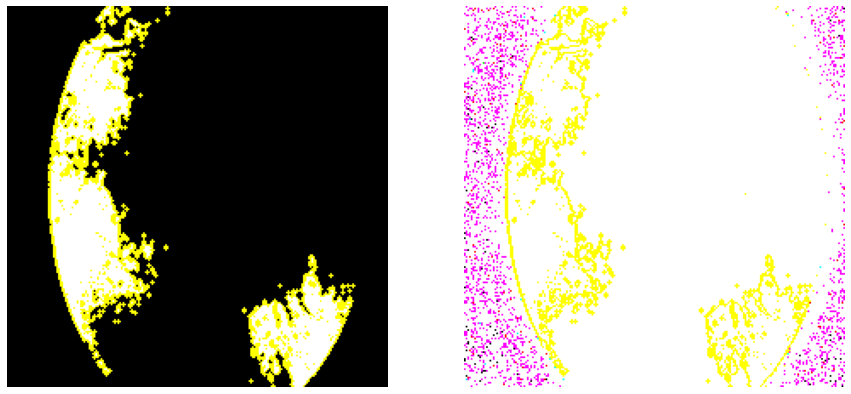

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
exp = explanation

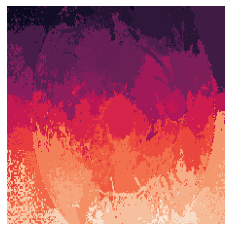

In [ ]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

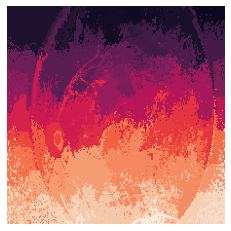

In [ ]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

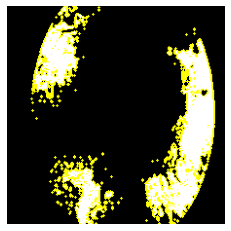

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=6,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=5,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

In [ ]:
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

AttributeError: ignored

4 th stage

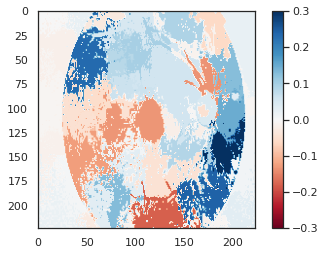

In [ ]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

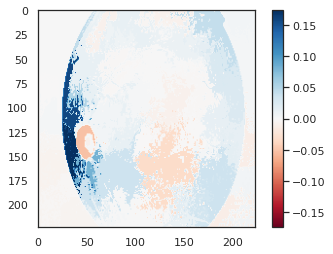

In [ ]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

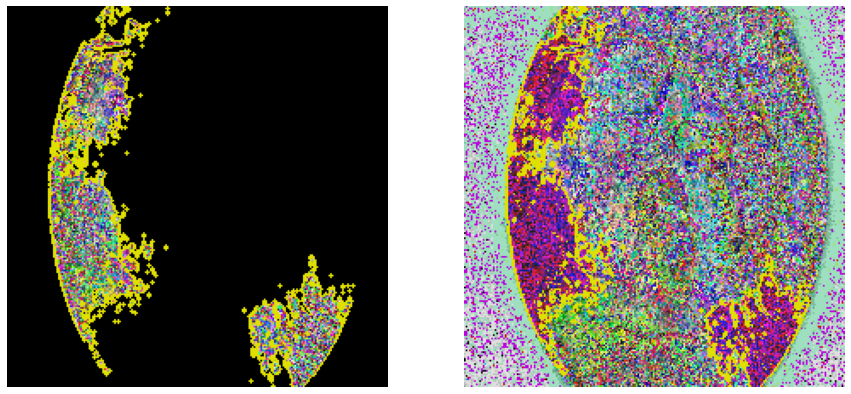

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow((mark_boundaries(temp_1, mask_1)*223).astype('uint8'))
ax2.imshow((mark_boundaries(temp_2, mask_2)*223).astype('uint8'))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_normal.png')

In [ ]:
def show_original_image(image_path):
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.show()

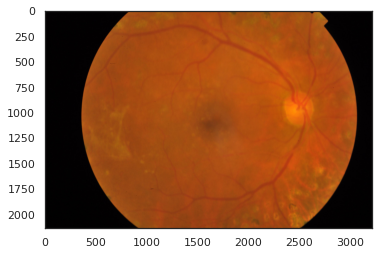

In [ ]:
show_original_image(path_to_zero)

In [ ]:
path_to_NDR = "/content/drive/MyDrive/aptos_ml_data/train_images/0024cdab0c1e.png"

In [ ]:
images = read_image(path_to_NDR)
images = np.array(images, dtype=np.double)

In [ ]:
explanation = explainer.explain_instance(images[0], new_model.predict,top_labels=1, hide_color=0, num_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s 435ms/step


In [ ]:
exp = explanation

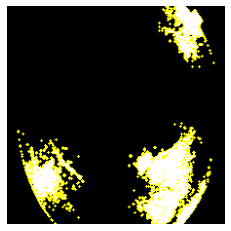

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=5,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

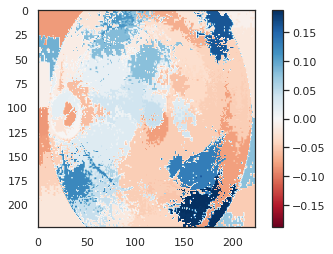

In [ ]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

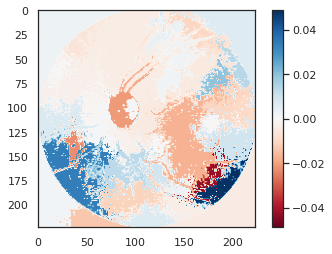

In [ ]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(exp, exp.top_labels[0])

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow((mark_boundaries(temp_1, mask_1)*255).astype('uint8'))
ax2.imshow((mark_boundaries(temp_2, mask_2)*255).astype('uint8'))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_pneu.png')

In [ ]:
show_original_image(path_to_NDR)

NameError: ignored